## Урок 7

### Домашнее задание

### Практическое задание:
1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import pandas as pd  # Импортируем библиотеку pandas и сокращаем её до pd
import numpy as np   # Импортируем библиотеку numpy и сокращаем её до np
import itertools # Импорт модуля itertools для работы с итерируемыми объектами

import seaborn as sns   # Импорт библиотеки Seaborn для визуализации данных
import matplotlib.pyplot as plt # Импортируем библиотеку matplotlib.pyplot для построения графиков

import shap # Импортируем библиотеку SHAP для объяснения моделей
import eli5 # Импортируем библиотеку eli5 для анализа и объяснения моделей
from eli5 import show_prediction # Импортируем функцию show_prediction из eli5 для отображения предсказаний моделей

# Импортируем функцию explain_weights_sklearn из eli5 для объяснения весов модели
from eli5.sklearn import explain_weights_sklearn

# Импортируем функцию format_as_dataframe из eli5 для форматирования объяснений в виде DataFrame
from eli5.formatters import format_as_dataframe

# Импортируем функцию format_as_text из eli5 для форматирования объяснений в текстовом виде
from eli5.formatters import format_as_text

import xgboost # Импортируем библиотеку XGBoost для работы с моделями градиентного бустинга

# Импортируем класс DecisionTreeClassifier из sklearn для работы с решающими деревьями
from sklearn.tree import DecisionTreeClassifier

# Импортируем класс OptimalBinning из optbinning для оптимального биннинга данных
from optbinning import OptimalBinning

# Импотрируем модуль для визуализации JavaScript
shap.initjs()

# Импортируем необходимые метрики из библиотеки sklearn.metrics
from sklearn.metrics import (
    f1_score,            # F1-мера
    roc_auc_score,       # Площадь под ROC-кривой
    roc_curve,           # ROC-кривая
    precision_score,     # Точность
    classification_report,  # Отчёт о классификации
    precision_recall_curve,  # Кривая точность-полнота
    confusion_matrix,    # Матрица ошибок
    accuracy_score,      # Точность
    recall_score         # Полнота
)
 
# Импортируем класс LogisticRegression для логистической регрессии
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier  # Импорт класса CatBoostClassifier из библиотеки CatBoost
from sklearn.ensemble import RandomForestClassifier  # Импорт класса RandomForestClassifier из scikit-learn
from sklearn.ensemble import GradientBoostingClassifier  # Импорт класса GradientBoostingClassifier из scikit-learn

# Импортируем функцию train_test_split для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline, make_pipeline  # Импорт классов Pipeline и make_pipeline из scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin  # Импорт базовых классов BaseEstimator и TransformerMixin
from sklearn.pipeline import FeatureUnion  # Импорт класса FeatureUnion из scikit-learn
from sklearn.preprocessing import StandardScaler  # Импорт класса StandardScaler из scikit-learn



import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Импортируем библиотеку ssl для настройки контекста SSL
import ssl

# Устанавливаем не проверять сертификаты SSL
ssl._create_default_https_context = ssl._create_unverified_context

%matplotlib inline

# Настраиваем формат вывода графиков в виде векторных изображений (SVG)
# %config InlineBackend.figure_format = 'svg'

2023-11-13 18:25:48.523052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

### <span style="color:#4f3605">AIDS Clinical Trials Group Study 175</span>

<span style="color:#4f3605">*Датасет AIDS Clinical Trials Group Study 175 содержит статистические данные о пациентах, у которых был диагностирован СПИД (Синдром приобретенного иммунодефицита). Этот датасет был создан для исследования эффективности двух различных методов лечения СПИДа. Вот информация о датасете:*

<span style="color:#4f3605">*__Цель создания датасета:__*
- <span style="color:#4f3605">*Исследование эффективности двух разных типов лечения СПИДа.*

<span style="color:#4f3605">*__Финансирование создания датасета:__*
- <span style="color:#4f3605">*AIDS Clinical Trials Group (Группа клинических исследований СПИДа) Национального института аллергии и инфекционных болезней.*
- <span style="color:#4f3605">*Общие исследовательские центры, финансируемые Национальным центром по исследованиям.*

<span style="color:#4f3605">*__Что представляют собой экземпляры (инстансы) в этом датасете:__*
- <span style="color:#4f3605">*Медицинские записи*
- <span style="color:#4f3605">*Пациенты с СПИДом*
- <span style="color:#4f3605">*Данные о пациентах из США*

<span style="color:#4f3605">*__Рекомендуемые разделения данных:__*
- <span style="color:#4f3605">*Можно использовать перекрестную проверку (cross-validation) или однократное разделение выборки на обучающую и тестовую.*

<span style="color:#4f3605">*__Описание признаков:__*

<span style="color:#4f3605">*1. `pidnum` (ID) - Целое число - Идентификационный номер пациента.*
    
<span style="color:#4f3605">*2. `cid` (Целевая переменная) - Бинарная - Индикатор цензурирования (1 = событие, 0 = цензурирование).*
    
<span style="color:#4f3605">*3. `time` - Целое число - Время до события или цензурирования.*
    
<span style="color:#4f3605">*4. `trt` - Целое число - Индикатор лечения (0 = ZDV, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI).*
    
<span style="color:#4f3605">*5. `age` - Целое число - Возраст пациента на момент начала исследования.*
    
<span style="color:#4f3605">*6. `wtkg` - Непрерывная - Вес пациента на момент начала исследования (в килограммах).*
    
<span style="color:#4f3605">*7. `hemo` - Бинарная - Гемофилия (0 = нет, 1 = да).*
    
<span style="color:#4f3605">*8. `homo` - Бинарная - Сексуальная ориентация (0 = нет гомосексуальной активности, 1 = есть).*
    
<span style="color:#4f3605">*9. `drugs` - Бинарная - История интравенозного употребления наркотиков (0 = нет, 1 = да).*
    
<span style="color:#4f3605">*10. `karnof` - Целое число - Оценка Карнофски (шкала от 0 до 100).*
    
<span style="color:#4f3605">*11. `oprior` - Бинарная - Применение противоретровирусных препаратов до начала исследования (0 = нет, 1 = да).*
    
<span style="color:#4f3605">*12. `z30` - Бинарная - Применение препарата ZDV в течение 30 дней до начала исследования (0 = нет, 1 = да).*
    
<span style="color:#4f3605">*13. `zprior` - Бинарная - Применение препарата ZDV до начала исследования (0 = нет, 1 = да).*
    
<span style="color:#4f3605">*14. `preanti` - Целое число - Количество дней до начала исследования, в течение которых применялась антиретровирусная терапия.*
    
<span style="color:#4f3605">*15. `race` - Целое число - Раса (0 = белый, 1 = не-белый).*
    
<span style="color:#4f3605">*16. `gender` - Бинарная - Пол (0 = женский, 1 = мужской).*
    
<span style="color:#4f3605">*17. `str2` - Бинарная - История антиретровирусной терапии (0 = нет опыта, 1 = есть опыт).*
    
<span style="color:#4f3605">*18. `strat` - Целое число - Стратификация по истории антиретровирусной терапии.*
    
<span style="color:#4f3605">*19. `symptom` - Бинарная - Индикатор симптомов (0 = асимптоматический, 1 = с симптомами).*
    
<span style="color:#4f3605">*20. `treat` - Бинарная - Индикатор лечения (0 = только ZDV, 1 = другие виды лечения).*
    
<span style="color:#4f3605">*21. `offtrt` - Бинарная - Индикатор прекращения лечения до 96 ± 5 недель (0 = нет, 1 = да).*
    
<span style="color:#4f3605">*22. `cd40` - Целое число - Уровень CD4 на момент начала исследования.*
    
<span style="color:#4f3605">*23. `cd420` - Целое число - Уровень CD4 на 20 ± 5 неделях.*
    
<span style="color:#4f3605">*24. `cd80` - Целое число - Уровень CD8 на момент начала исследования.*
    
<span style="color:#4f3605">*25. `cd820` - Целое число - Уровень CD8 на 20 ± 5 неделях.*
___

<span style="color:#4f3605">*Этот датасет содержит разнообразные характеристики пациентов, и его цель состоит в исследовании выживаемости и эффективности различных методов лечения СПИДа.*

<span style="color:#4f3605">*__Суть задачи прогнозирования в данном датасете заключается в предсказании, умер ли каждый пациент в определенный период времени или нет. То есть, задача заключается в бинарной классификации, где целевой признак (`cid`) указывает на то, произошла ли смерть пациента (1 - смерть) или нет (0 - цензурирование, то есть пациент не умер в заданный период).__*

<span style="color:#4f3605">*__Таким образом, цель этой задачи состоит в разработке модели, которая на основе характеристик и медицинских данных пациентов будет способна предсказывать их выживаемость или вероятность смерти в определенный временной интервал.__*

In [2]:
# !pip install ucimlrepo

In [3]:
# Импортируем необходимую функцию fetch_ucirepo из библиотеки ucimlrepo
from ucimlrepo import fetch_ucirepo

# Загружаем набор данных с идентификатором 890 и сохраняем его в переменной aids_clinical_trials_group_study_175
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890)

# Извлекаем признаки (X) и целевую переменную (y) из загруженных данных
X = aids_clinical_trials_group_study_175.data.features
y = aids_clinical_trials_group_study_175.data.targets

# Выводим первые несколько строк признаков (X) для предварительного анализа данных
X.head()

# Сохраняем признаки (X) в CSV-файл по указанному пути
X.to_csv('./data/X.csv')

# Сохраняем целевую переменную (y) в CSV-файл по указанному пути
y.to_csv('./data/y.csv')


### 2. Сделать обзорный анализ выбранного датасета

In [4]:
# Выводим информацию о датафрейме df
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   time     2139 non-null   int64  
 1   trt      2139 non-null   int64  
 2   age      2139 non-null   int64  
 3   wtkg     2139 non-null   float64
 4   hemo     2139 non-null   int64  
 5   homo     2139 non-null   int64  
 6   drugs    2139 non-null   int64  
 7   karnof   2139 non-null   int64  
 8   oprior   2139 non-null   int64  
 9   z30      2139 non-null   int64  
 10  zprior   2139 non-null   int64  
 11  preanti  2139 non-null   int64  
 12  race     2139 non-null   int64  
 13  gender   2139 non-null   int64  
 14  str2     2139 non-null   int64  
 15  strat    2139 non-null   int64  
 16  symptom  2139 non-null   int64  
 17  treat    2139 non-null   int64  
 18  offtrt   2139 non-null   int64  
 19  cd40     2139 non-null   int64  
 20  cd420    2139 non-null   int64  
 21  cd80     2139 

In [5]:
# Выводим данные о размере датасета
X.shape

(2139, 23)

In [6]:
# Выводим данные о признаках датасета
X.columns

Index(['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof',
       'oprior', 'z30', 'zprior', 'preanti', 'race', 'gender', 'str2', 'strat',
       'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820'],
      dtype='object')

In [7]:
# Выводим описательные статистики для признаков в X
X.describe()


,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,...,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,1.520804,35.248247,75.125311,0.084151,0.661057,0.131370,95.446470,0.021973,0.550257,...,0.827957,0.585788,1.979897,0.172978,0.751286,0.362786,350.501169,371.307153,986.627396,935.369799
std,292.274324,1.127890,8.709026,13.263164,0.277680,0.473461,0.337883,5.900985,0.146629,0.497584,...,0.377506,0.492701,0.899053,0.378317,0.432369,0.480916,118.573863,144.634909,480.197750,444.976051
min,14.000000,0.000000,12.000000,31.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,49.000000,40.000000,124.000000
25%,727.000000,1.000000,29.000000,66.679200,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,263.500000,269.000000,654.000000,631.500000
50%,997.000000,2.000000,34.000000,74.390400,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,340.000000,353.000000,893.000000,865.000000
75%,1091.000000,3.000000,40.000000,82.555200,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,423.000000,460.000000,1207.000000,1146.500000
max,1231.000000,3.000000,70.000000,159.939360,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1199.000000,1119.000000,5011.000000,6035.000000


In [8]:
# Выводим количество уникальных значений в целевой переменной y и их частоты
# Данные несбалансированы, это нужно учесть в дальнейшем
y.value_counts()


cid
0      1618
1       521
dtype: int64

### 3. Cделать feature engineering

In [9]:
# Преобразуем целевую переменную y в одномерный массив
y = y.values.flatten()

# Разделяем данные на обучающий и тестовый наборы с использованием функции train_test_split
# test_size=0.2 указывает, что 20% данных будут использоваться как тестовый набор
# stratify=y гарантирует стратификацию, сохраняя баланс классов в обучающем и тестовом наборах
# random_state=42 задает начальное состояние для воспроизводимости разделения данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Создаем список continuous_columns, включая признаки с более чем 2 уникальными значениями
continuous_columns = [col for col in X.columns if X[col].nunique() > 2]

# Создаем список binary_columns, включая признаки с не более чем 2 уникальными значениями
binary_columns = [col for col in X.columns if X[col].nunique() <= 2]


In [10]:
# Задаем имя переменной, с которой будем работать
variable = 'time'

# Извлекаем значения признака 'time' из обучающего набора данных
x_opt = X_train[variable].values

# Задаем целевую переменную для оптимизации
y_opt = y_train

# Создаем экземпляр класса OptimalBinning для оптимизации биннинга переменной 'time'
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

# Обучаем оптимальное разбиение с использованием обучающих данных
optb.fit(x_opt, y_opt)

# Преобразуем обучающий набор данных, заменяя значения 'time' на их веса информативности (WOE)
X_train['time'] = optb.transform(X_train['time'], metric="woe")

# Преобразуем тестовый набор данных с использованием того же оптимального биннинга
X_test['time'] = optb.transform(X_test['time'], metric="woe")


In [11]:
# Создаем Series из признака 'time' в обучающем наборе данных и подсчитываем уникальные значения и их частоты
pd.Series(X_train['time']).value_counts()


 3.664760    733
-1.702033    393
 0.600163    193
 1.713793    164
-1.849085    128
-0.557043    100
Name: time, dtype: int64

In [12]:
# Получаем таблицу биннинга из объекта OptimalBinning
binning_table = optb.binning_table

# Определяем тип таблицы биннинга
type(binning_table)

# Строим оптимальное биннинг-решение на основе таблицы биннинга
optimal_binning = binning_table.build()

# Выводим оптимальное биннинг-решение
print(optimal_binning)


                      Bin  Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 313.50)    128   0.074810         42     86    0.671875   
1        [313.50, 834.50)    393   0.229690        142    251    0.638677   
2        [834.50, 912.50)    100   0.058445         64     36    0.360000   
3        [912.50, 987.50)    193   0.112800        164     29    0.150259   
4       [987.50, 1027.50)    164   0.095850        155      9    0.054878   
5          [1027.50, inf)    733   0.428404        727      6    0.008186   
6                 Special      0   0.000000          0      0    0.000000   
7                 Missing      0   0.000000          0      0    0.000000   
Totals                      1711   1.000000       1294    417    0.243717   

             WoE        IV        JS  
0      -1.849085  0.321329  0.035273  
1      -1.702033  0.837709  0.093662  
2      -0.557043  0.020539  0.002535  
3       0.600163  0.034326  0.004227  
4       1.713793  0.168296  0.0187

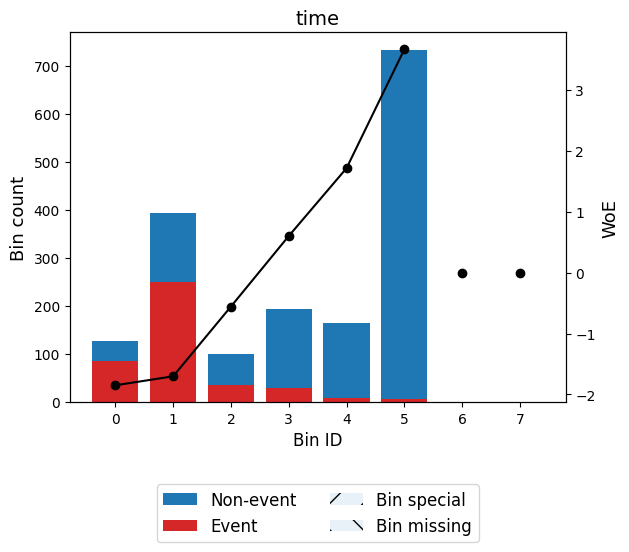

In [13]:
# Визуализируем таблицу биннинга, используя метрику "WOE" (Weight of Evidence)
binning_table.plot(metric="woe")


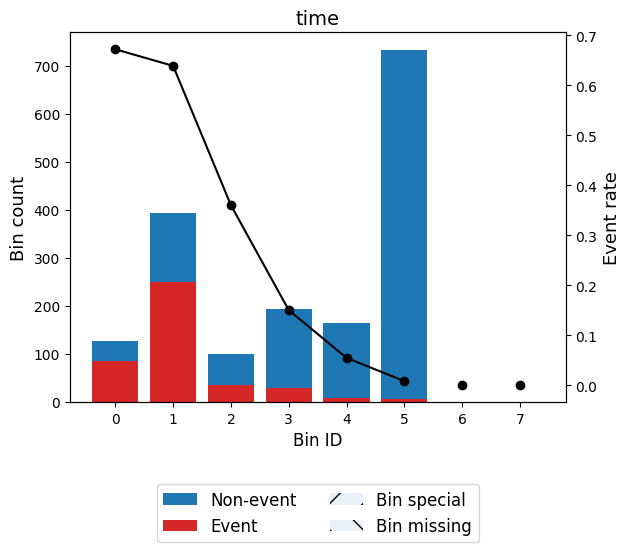

In [14]:
# Визуализируем таблицу биннинга, используя метрику "event_rate" (частота событий)
binning_table.plot(metric="event_rate")


In [15]:
# Класс FeatureSelector предназначен для выбора указанного столбца из DataFrame
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

# Класс NumberSelector предназначен для выбора одного числового столбца из DataFrame
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

# Класс OHEEncoder предназначен для выполнения one-hot encoding на указанном столбце DataFrame
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [16]:
# Создаем пустой список final_transformers для хранения трансформаторов
final_transformers = []

# Для каждого категориального столбца создаем трансформатор, который включает в себя FeatureSelector и OHEEncoder
for cat_col in binary_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),  # Выбор указанного столбца
        ('ohe', OHEEncoder(key=cat_col))  # Применение one-hot encoding
    ])
    final_transformers.append((cat_col, cat_transformer))

# Для каждого непрерывного столбца создаем трансформатор, который включает в себя NumberSelector и StandardScaler
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),  # Выбор указанного числового столбца
        ('standard', StandardScaler())  # Стандартизация значений
    ])
    final_transformers.append((cont_col, cont_transformer))

In [17]:
# Создаем объединение трансформаторов feats с использованием final_transformers
feats = FeatureUnion(final_transformers)

# Создаем пайплайн feature_processing, который включает в себя объединение трансформаторов feats
feature_processing = Pipeline([('feats', feats)])

### 4. Обучить любой классификатор (какой вам нравится)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Функция выводит и рисует матрицу ошибок.
    Нормализация может быть применена, установив `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
def get_metrics(probs, model):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    # Извлечение значений из матрицы ошибок
    TN = cnf_matrix[0][0]  # True Negative
    FN = cnf_matrix[1][0]  # False Negative
    TP = cnf_matrix[1][1]  # True Positive
    FP = cnf_matrix[0][1]  # False Positive

    # Вычисление True Positive Rate (TPR) или чувствительности
    TPR = TP / (TP + FN)

    # Вычисление False Positive Rate (FPR) или вероятности ложного срабатывания
    FPR = FP / (FP + TN)

    # Вычисление True Negative Rate (TNR) или специфичности
    TNR = TN / (FP + TN)
    return model, thresholds[ix], fscore[ix], precision[ix], \
            recall[ix], roc_auc_score(y_test, probs), \
            TPR, FPR, TNR

In [20]:
# Создаем словарь models, в котором ключами являются названия моделей, а значениями - соответствующие модели
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=2),  # Логистическая регрессия
    'CatBoostClassifier': CatBoostClassifier(n_estimators=900, 
                                             max_depth=6, 
                                             learning_rate=0.03, 
                                             l2_leaf_reg=20,
                                             silent=True, 
                                             random_state=42),  # CatBoost
    'RandomForestClassifier': RandomForestClassifier(random_state=2),  # Случайный лес
    'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.06, max_depth=3, min_samples_leaf=1,
                                              n_estimators=200, random_state=2)  # Градиентный бустинг
}

In [21]:
best_score = 0  # Инициализируем переменную для хранения лучшего значения метрики
best_model = None  # Инициализируем переменную для хранения лучшей модели

# Проходим по каждой модели и её имени в словаре models
for modelname, model in models.items():
    # Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
    pipeline = Pipeline([
        ('features', feats),
        (modelname, model)
    ])
    
    # Запуск кросс-валидации и оценка ROC AUC для текущей модели.
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score for {modelname} is {cv_score}+-{cv_score_std}')

    # Сравнение текущего показателя с лучшим показателем и обновление лучшего показателя и модели при необходимости
    if cv_score > best_score:
        best_score = cv_score
        best_model = model
        
# Создание пайплайна с лучшей моделью.
classifier = Pipeline([
    ('features', feats),
    ('classifier', best_model)
])

# Обучение пайплайна на всем тренировочном датасете с использованием лучшей модели.
classifier.fit(X_train, y_train)

# Прогнозирование вероятностей и вывод информации о наилучшей производительности модели.
preds = classifier.predict_proba(X_test)[:, 1]
print(f'\nНаилучшую производительность показал алгоритм {type(best_model).__name__}')

CV score for LogisticRegression is 0.9431406328688938+-0.018206783034191775
CV score for CatBoostClassifier is 0.9416580882387809+-0.01473085665366172
CV score for RandomForestClassifier is 0.9281053891163508+-0.022311773901368615
CV score for GradientBoostingClassifier is 0.9434588764203724+-0.014371172682961644

Наилучшую производительность показал алгоритм GradientBoostingClassifier


In [22]:
# Создаем словарь models_metrics для хранения метрик производительности моделей
models_metrics = {
    'model': [],  # Имя модели
    'best_threshold': [],  # Лучший порог для бинаризации предсказаний
    'f-score': [],  # F-мера
    'precision': [],  # Точность
    'recall': [],  # Полнота (recall)
    'roc-auc': [],  # Площадь под ROC-кривой
    'true_positive_rate': [],  # True Positive Rate (чувствительность)
    'false_positive_rate': [],  # False Positive Rate (специфичность)
    'true_negative_rate': []  # True Negative Rate
}

In [23]:
# Проходим по каждой модели и её имени в словаре models
for modelname, model in models.items():
    # Создаем пайплайн, который включает в себя трансформаторы feats и текущую модель
    classifier_pipeline = Pipeline([
        ('features', feats),
        ('classifier', model)
    ])
    
    # Обучаем пайплайн на всем тренировочном датасете с использованием лучшей модели
    classifier_pipeline.fit(X_train, y_train)
    
    # Прогнозируем вероятности на тестовом датасете
    preds = classifier_pipeline.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики производительности модели с использованием функции get_metrics
    for key_value, metric in zip(models_metrics.keys(), get_metrics(preds, modelname)):
        if isinstance(metric, (int, float)):
            # Если метрика числовая, округляем её до 4 знаков после запятой и добавляем в словарь
            metric = f'{metric:.4f}'
            if metric not in models_metrics.get(key_value):
                models_metrics[key_value].append(float(metric))
            else:
                pass
        else:
            # Если метрика не числовая, добавляем в словарь
            if metric not in models_metrics.get(key_value):
                models_metrics[key_value].append(metric)
            else:
                pass

In [24]:
# Создаем DataFrame df_models_metrics из словаря models_metrics
df_models_metrics = pd.DataFrame(models_metrics)

# Выводим DataFrame с метриками производительности моделей
df_models_metrics

,model,best_threshold,f-score,precision,recall,roc-auc,true_positive_rate,false_positive_rate,true_negative_rate
0,LogisticRegression,0.4730,0.8200,0.8542,0.7885,0.9385,0.7788,0.0432,0.9568
1,CatBoostClassifier,0.5551,0.8000,0.8571,0.7500,0.9323,0.7404,0.0401,0.9599
2,RandomForestClassifier,0.4100,0.7793,0.7615,0.7981,0.9246,0.7788,0.0772,0.9228
3,GradientBoostingClassifier,0.5423,0.7959,0.8478,0.7500,0.9283,0.7404,0.0432,0.9568


Confusion matrix, without normalization
[[305  19]
 [ 25  79]]


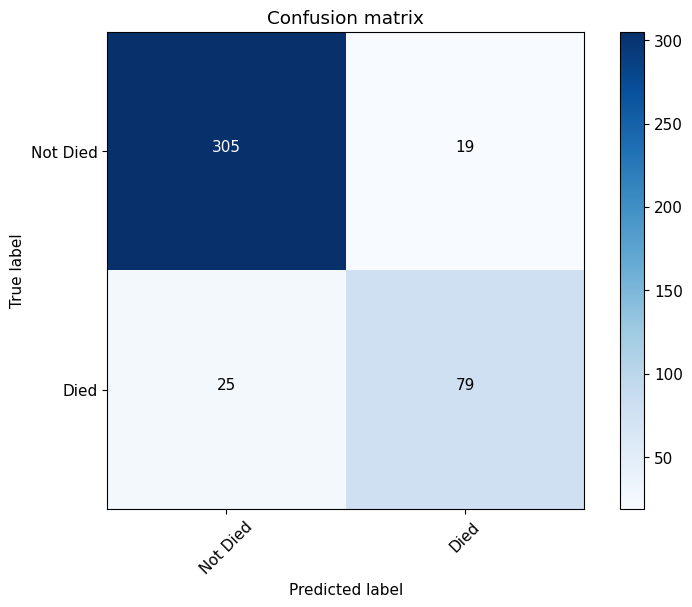

In [25]:
# Устанавливаем размер шрифта для графика
font = {'size' : 11}
plt.rc('font', **font)

# Вычисляем матрицу ошибок
cnf_matrix = confusion_matrix(y_test, preds > df_models_metrics.loc[df_models_metrics['roc-auc'].idxmax(),\
                                                                    'best_threshold'])
# Создаем график
plt.figure(figsize=(8, 6))

# Выводим матрицу ошибок с помощью функции plot_confusion_matrix
plot_confusion_matrix(cnf_matrix, classes=['Not Died', 'Died'],
                      title='Confusion matrix')
# Сохраняем график в файл
plt.savefig("./image/conf_matrix_1.png")

# Отображаем график
plt.show()

### 5. Разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%

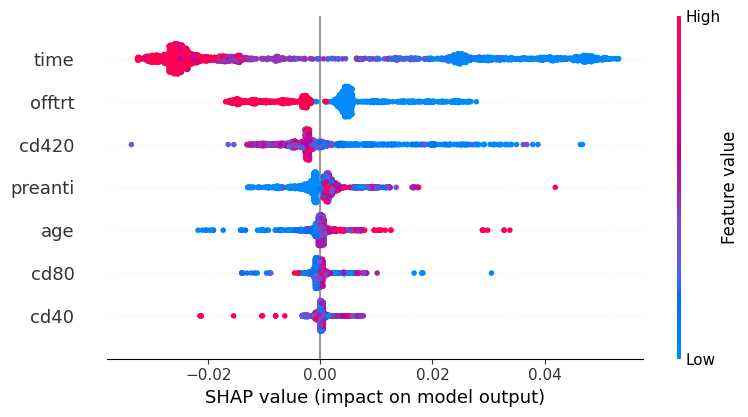

In [26]:
# Обучаем модель XGBoost с указанным параметром "learning_rate" и данными X_train и y_train
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train))

# Создаем объяснитель (explainer) SHAP для обученной модели
explainer = shap.TreeExplainer(model)

# Вычисляем значения SHAP для обучающего набора данных
shap_values = explainer.shap_values(X_train)

# Строим суммарный график SHAP значений для анализа важности признаков
shap.summary_plot(shap_values, X_train, max_display=7)


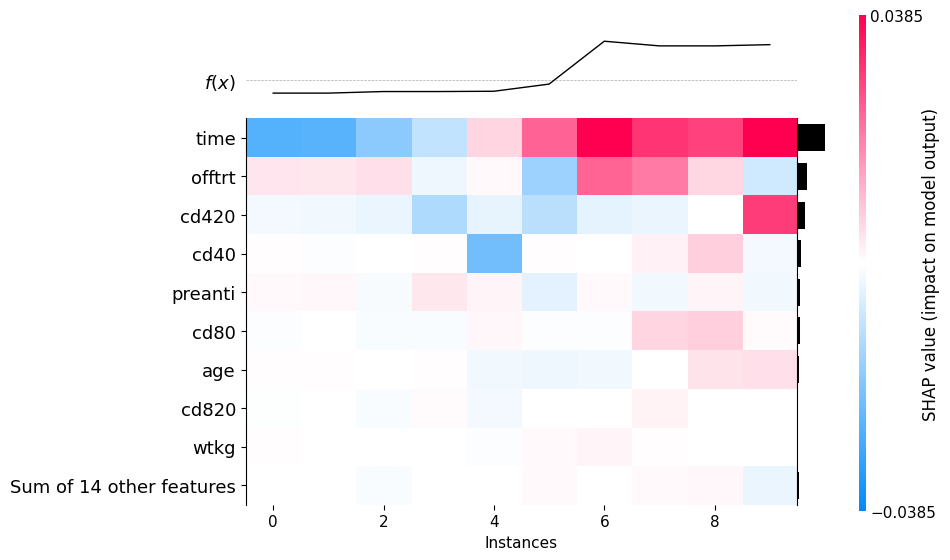

In [27]:
# Обучаем модель XGBoost с указанным параметром "learning_rate" и данными X_train и y_train
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train))

# Создаем объяснитель (explainer) SHAP для обученной модели
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP-значения для обучающего набора данных
shap_values = explainer.shap_values(X_train)

# Определяем количество строк (n), которые будут использоваться для анализа SHAP значений
n = 10

# Извлекаем SHAP-значения для первых n строк обучающего набора данных
shap_values = explainer(X_train.iloc[:n])

# Строим тепловую карту (heatmap) для анализа влияния признаков на предсказания модели
shap.plots.heatmap(shap_values)


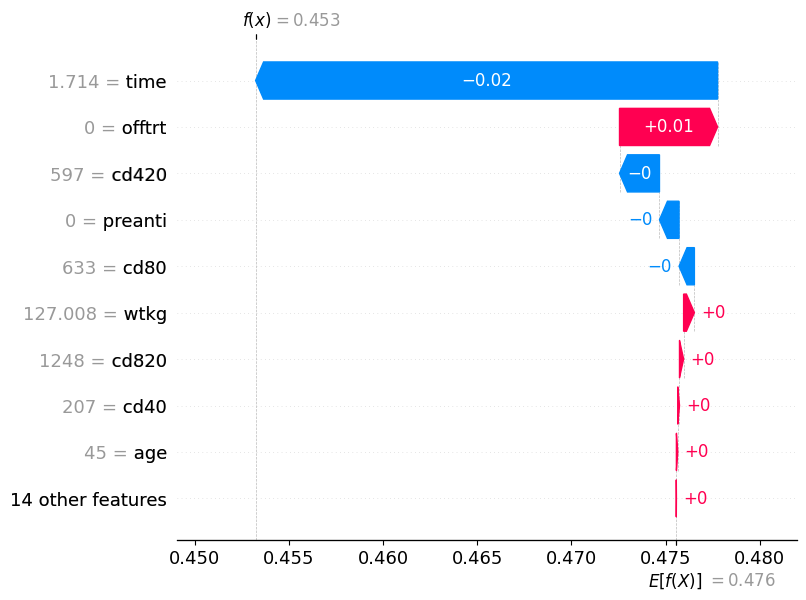

In [28]:
# Определяем индекс (idx) строки данных, для которой хотим провести анализ SHAP значений
idx = 100

# Вычисляем SHAP-значения для одной строки данных с индексом idx
shap_values_one = explainer(X_train.iloc[idx:idx+1])

# Строим водопадную диаграмму (waterfall plot) для анализа влияния признаков на предсказания модели
shap.plots.waterfall(shap_values_one[0], max_display=10, show=True)


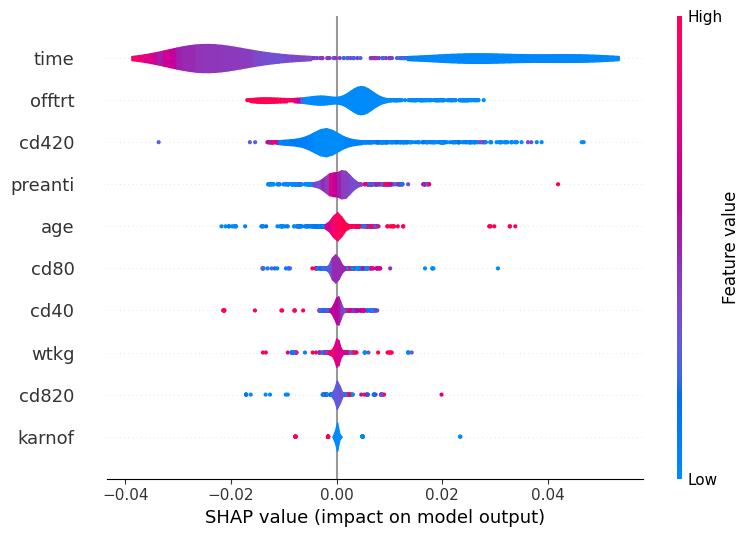

In [29]:
# Обучаем модель XGBoost с указанным параметром "learning_rate" и данными X_train и y_train
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train))

# Создаем объяснитель (explainer) SHAP для обученной модели
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP-значения для обучающего набора данных
shap_values = explainer.shap_values(X_train)

# Строим суммарный график SHAP значений с типом графика "скрипка" (violin) для анализа важности признаков
# и ограничиваем количество отображаемых признаков до 10
shap.summary_plot(shap_values, X_train, plot_type="violin", max_display=10)


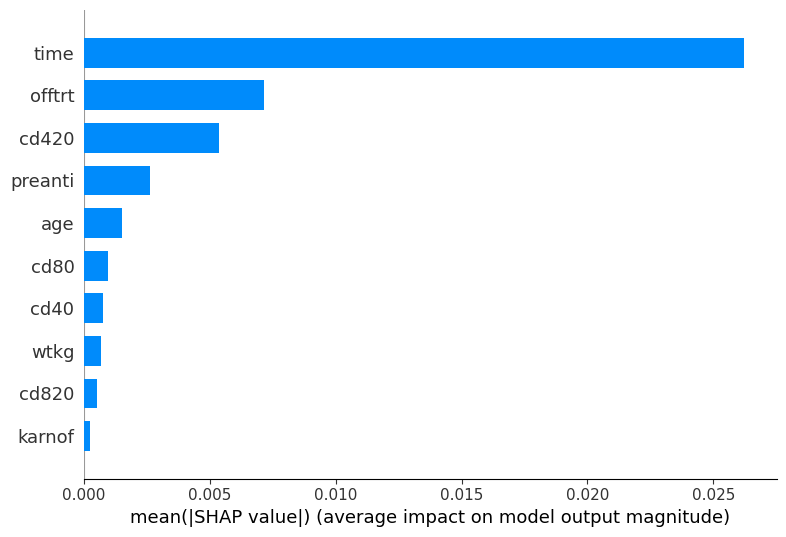

In [30]:
# Обучаем модель XGBoost с указанным параметром "learning_rate" и данными X_train и y_train
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train))

# Создаем объяснитель (explainer) SHAP для обученной модели
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP-значения для обучающего набора данных
shap_values = explainer.shap_values(X_train)

# Строим суммарный график SHAP значений с использованием типа графика "бар" (bar) для анализа важности признаков
# и ограничиваем количество отображаемых признаков до 10
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)


In [31]:
# Используем библиотеку eli5 для отображения весов модели XGBoost и указываем имена признаков
eli5.show_weights(model, feature_names=X_train.columns.tolist())


Weight,Feature
0.4238,time
0.3523,offtrt
0.0535,cd420
0.0249,preanti
0.0223,age
0.0184,cd820
0.0179,cd40
0.0169,karnof
0.0169,trt
0.0136,cd80


In [32]:
# Используем библиотеку eli5 для отображения предсказания модели XGBoost для определенной строки данных
# с индексом n и указываем имена признаков и отображение значений признаков
show_prediction(model, X_train.iloc[n], feature_names=X_train.columns.tolist(), show_feature_values=True)


### 6. Для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [33]:
# Обучаем модель XGBoost с указанным параметром "learning_rate" и данными X_train и y_train
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train))

# Создаем объяснитель (explainer) SHAP для обученной модели
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP-значения для обучающего набора данных
shap_values = explainer.shap_values(X_train)

# Определяем индекс (idx) строки данных, для которой хотим провести анализ SHAP значений
idx = 7

# Строим график SHAP-значений с помощью функции force_plot для выбранной строки данных
shap.force_plot(explainer.expected_value, shap_values[idx:idx+1], X_train.iloc[idx:idx+1])


In [34]:
# Обучаем модель XGBoost с указанным параметром "learning_rate" и данными X_train и y_train
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train))

# Создаем объяснитель (explainer) SHAP для обученной модели
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP-значения для обучающего набора данных
shap_values = explainer.shap_values(X_train)

# Определяем индекс (idx) строки данных, до которой хотим провести анализ SHAP значений
idx = 7

# Строим график SHAP-значений с помощью функции force_plot для первых idx строк данных
shap.force_plot(explainer.expected_value, shap_values[:idx], X_train.iloc[:idx])


In [35]:
# Определяем переменную n
n = -1

# Создаем модель решающего дерева DecisionTreeClassifier с заданным случайным состоянием
tree_model = DecisionTreeClassifier(random_state=1)

# Обучаем модель на обучающем наборе данных, ограничивая количество строк данными до n
tree_model.fit(X_train.iloc[:n], y_train[:n])

# Создаем объяснение весов модели с использованием функции explain_weights_sklearn
explanation = explain_weights_sklearn(tree_model, feature_names=X_train.columns.tolist())

# Форматируем объяснение в виде DataFrame для лучшего отображения
format_as_dataframe(explanation)


,feature,weight
0,time,0.432221
1,cd420,0.117559
2,offtrt,0.079471
3,cd80,0.065580
4,cd40,0.055346
5,wtkg,0.052456
6,age,0.049527
7,preanti,0.047550
8,cd820,0.026389
9,karnof,0.015159


### <span style="color:#4f0525">Выводы:

<span style="color:#4f0525">Исходя из результатов анализа, можно сделать следующие обобщенные выводы:</span>

<span style="color:#4f0525">1. **Время (`time`):** Наиболее важным фактором для прогнозирования исходов является время, которое прошло до события или цензурирования. Это ожидаемо, так как в медицинских исследованиях длительность наблюдения играет фундаментальную роль. Большая часть информации о прогнозах основана на том, сколько времени пациенты находятся под наблюдением.</span>

<span style="color:#4f0525">2. **Индикатор прекращения лечения до 96 ± 5 недель (`offtrt`):** Этот признак указывает на важность соблюдения лечения и его эффективности. Если пациенты досрочно прекращают лечение, это может негативно сказаться на исходах. Таким образом, не только вид лечения важен, но и его непрерывность.</span>

<span style="color:#4f0525">3. **Уровень CD4 на 20 ± 5 неделях (`cd420`):** Уровень CD4 важен для прогнозирования исходов, что свидетельствует о важности иммунного статуса пациентов. Повышение CD4 может быть связано с более благоприятными исходами.</span>

<span style="color:#4f0525">4. **Количество дней до начала исследования (`preanti`):** Этот признак указывает на продолжительность антиретровирусной терапии до начала исследования. Большее количество дней терапии до начала исследования может быть связано с лучшими исходами, что подчеркивает важность продолжительности лечения.</span>

<span style="color:#4f0525">5. **Возраст (`age`):** Возраст пациентов остается значимым фактором, что подтверждает его влияние на результаты. Возможно, с возрастом связаны различия в риске и прогнозе.</span>

<span style="color:#4f0525">6. **Уровень CD8 на момент начала исследования (`cd80`):** Уровень CD8 также оказывает влияние на исходы. Высокий уровень CD8 может быть связан с более неблагоприятными исходами, и это может отражать активность воспалительных процессов.</span>

<span style="color:#4f0525">Эти выводы подчеркивают множество факторов, влияющих на результаты медицинских исследований в области ВИЧ-инфекции. Данные выводы могут быть полезными для улучшения стратегий лечения и управления пациентами.</span>